In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
from _aux import loadmat_h5
import os
import SimpleITK as sitk
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from scipy import ndimage
#import skimage.measure

#import pyvista as pv # maybe use this for 3d?

In [161]:
data_dir = 'C:/Users/alber/Dropbox/AL_WG Lightbead Data/Method paper/Dictionary data/Rig E/'                           
fname = 'wayan_a2_r2_n200_labels.h5'  
labels = loadmat_h5(os.path.join(data_dir, fname))
# A path to a T1-weighted brain .nii image:
stack_file = f'{data_dir}wayan_a2_r2_green_mean_G.nii'

plot_dir = 'C:/Users/alber/Dropbox/AL_WG Lightbead Data/Method paper/Dictionary data/Rig E/wayan_a2_r2_ROI_plots'  

In [162]:
l = labels['labels']
#reshape into dimensions of stack (voxels in each ROI)
# lightbead
#roi_pos_raw = l.reshape((226,512,27))
#Rig E
roi_pos_raw = l.reshape((256,128,48))

# rotate image, flip so top of the brain is first
# LB only 
#roi_pos = np.flip(np.rot90(roi_pos_raw,k=2,axes=(0,1)),2)

#Rig E fwd mount
roi_pos = np.flip(np.rot90(roi_pos_raw,k=1,axes=(0,1)),2)


In [131]:
l.shape

(32768, 48)

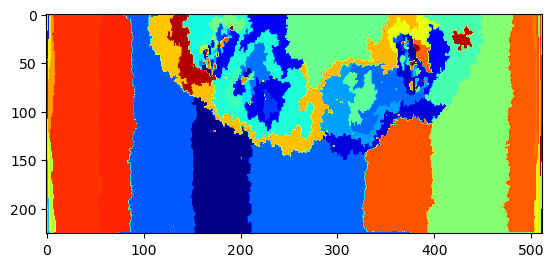

In [165]:
# Plot all rois for each slice
for slice_idx in [12]:#range(2):
    matplotlib.rcParams['pdf.fonttype']=42
    plt.figure()
    plt.imshow(roi_pos_raw[:,:,slice_idx],cmap = 'jet') #
    

In [29]:
# read in a volumetric image (revisit when correct nii files are uploaded)

#f'{data_dir}green_moco_subset/moco_green_volume_5.nii'

# Read the .nii image containing the volume with SimpleITK:
sitk_t1 = sitk.ReadImage(stack_file)

# and access the numpy array: (z, x, y)
volume_img_raw = sitk.GetArrayFromImage(sitk_t1)

volume_img_reordered = np.moveaxis(volume_img_raw, [0], [2])

# rotate image, flip so top of brain is first LB
#volume_img = np.flip(np.rot90(volume_img_reordered,k=1,axes=(0,1)),2)

# Rig E fwd mount
volume_img = np.flip(np.rot90(volume_img_reordered,k=2,axes=(0,1)),2)


In [18]:
# LIGHTBEAD ONLY: handle the offset (~5 pixels per slice in X, two stacks: 0-12, 13-27) WIP, how many overlaps
first_slice_center_idx = 6 #: 0-12, 13 slices
second_slice_start = 13
second_slice_center_idx = 20 #: 13-27, 15 slices

step_size = 5 #pixels
stack_offset = 10 #pixels
stack_yoffset = 25 #pixels

volume_shifted = np.zeros_like(volume_img)

for idx in range(27):
    if idx <= first_slice_center_idx:
        xoffset = (first_slice_center_idx-idx)*5
        volume_shifted[:,:,idx] = np.pad(volume_img[:,:,idx],((0,xoffset),(0,0)), mode = 'minimum')[xoffset:(226+xoffset),:]
    elif idx > first_slice_center_idx and idx < second_slice_start:
        xoffset = (idx-first_slice_center_idx)*5
        volume_shifted[:,:,idx] = np.pad(volume_img[:,:,idx],((xoffset,0),(0,0)), mode = 'minimum')[0:226,:]
    elif idx >= second_slice_start and idx <= second_slice_center_idx:
        xoffset = (second_slice_center_idx-idx)*5 + stack_offset
        volume_shifted[:,:,idx] = np.pad(volume_img[:,:,idx],
                                         ((0,xoffset),(0,stack_yoffset)),
                                         mode = 'minimum')[xoffset:(226+xoffset),stack_yoffset:(512+stack_yoffset)]
    elif idx > second_slice_center_idx:
        xoffset = (idx-second_slice_center_idx)*5 + stack_offset
        volume_shifted[:,:,idx] = np.pad(volume_img[:,:,idx],
                                         ((xoffset,0),(0,stack_yoffset)),
                                         mode = 'minimum')[xoffset:(226+xoffset),stack_yoffset:(512+stack_yoffset)]



# after padding, delete slices 9 is about the same as 13? let's delete slices 10-13 for now
volume_shifted_cut = np.delete(volume_shifted,[10, 11, 12, 13], axis=2)

In [15]:
volume_shifted_cut.shape

(226, 512, 23)

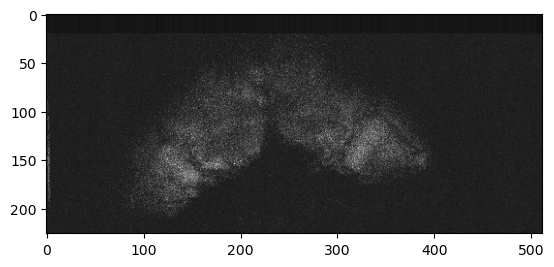

In [19]:
plt.imshow(volume_shifted[:,:,10],cmap='gray', vmin=70, vmax=130)

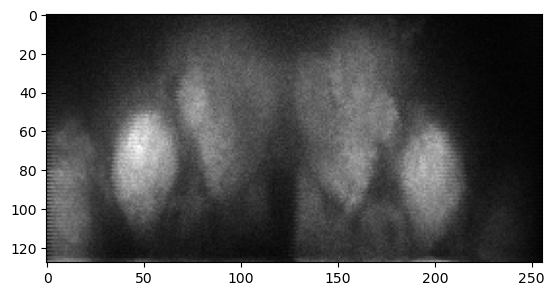

In [33]:
plt.imshow(volume_img[:,:,6],cmap='gray')#, vmin=0, vmax=10)

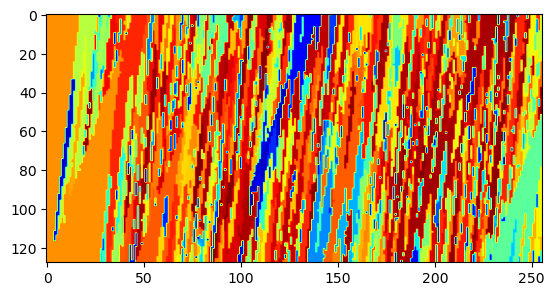

In [106]:
# Plot all rois for each slice
for slice_idx in [10]:#range(2):
    matplotlib.rcParams['pdf.fonttype']=42
    plt.figure()
    plt.imshow(roi_pos[:,:,slice_idx],cmap = 'jet')
    

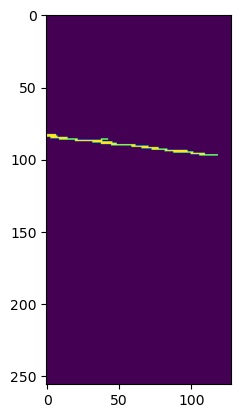

In [158]:
# Plot a given roi for a given slice with slice background?

slice_idx = 10
roi = 1


plt.figure()
plt.imshow(roi_pos_raw[:,:,slice_idx]==roi)



In [77]:
data = pd.read_csv(data_dir + 'GCaMP6f_06212024_a1_r2_audiocorr_before.txt', header = None)

audio_correlated = data[0]

In [78]:
# This gives the the roi number and the slice it is located in for each of the auditory rois (conversion by ROI num/frame, flip)
slice_audio = np.size(roi_pos,2)-(audio_correlated//1000)-1
roi_audio = audio_correlated - (1000 * (audio_correlated//1000))

In [65]:
slice_audio

0       47
1       47
2       47
3       47
4       47
        ..
2395     3
2396     3
2397     3
2398     3
2399     3
Name: 0, Length: 2400, dtype: int64

In [79]:
# precompute masked ROI volume by finding audio-correlated ROIs

audio_rois = np.zeros_like(roi_pos)

for slice_idx in range(27):
    for s,r in zip(slice_audio, roi_audio):
        if s == slice_idx:
            #print(r)
            save_filter = (roi_pos[:,:,s] == r)
            audio_rois[save_filter,s] = r

audio_rois_masked = np.ma.masked_where(audio_rois == 0, audio_rois)

In [ ]:
audio_rois.shape

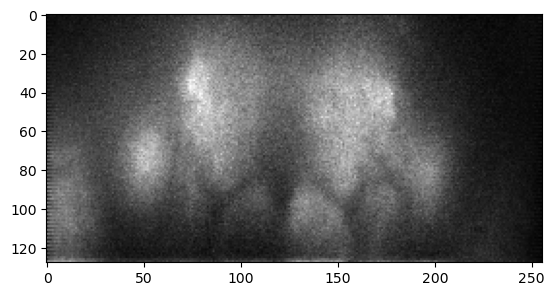

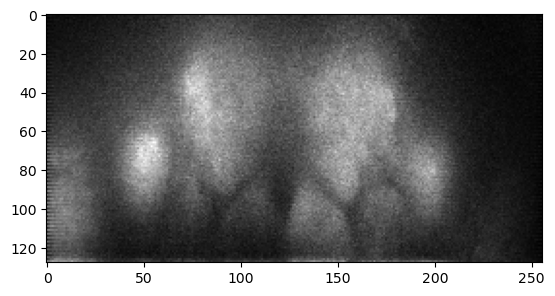

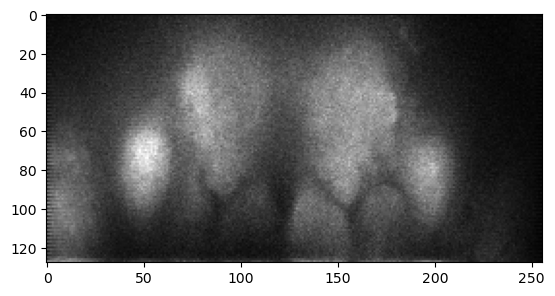

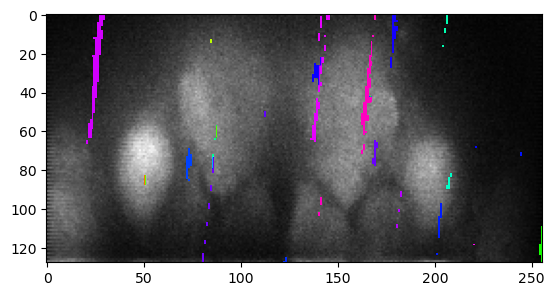

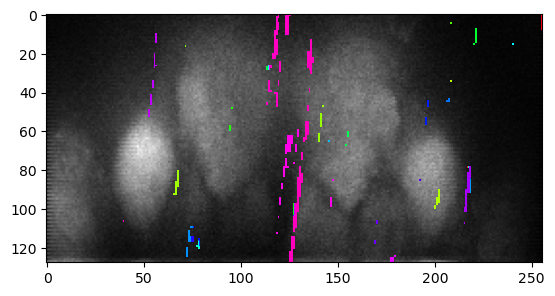

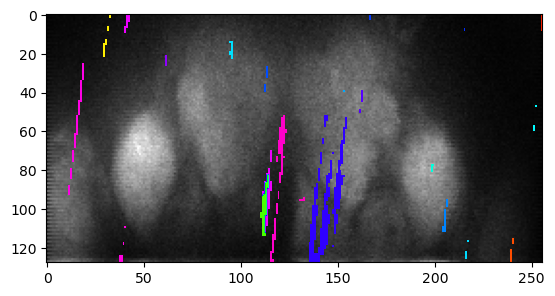

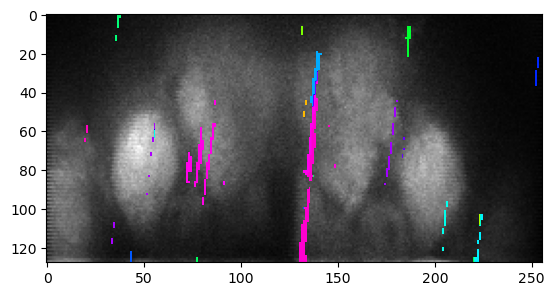

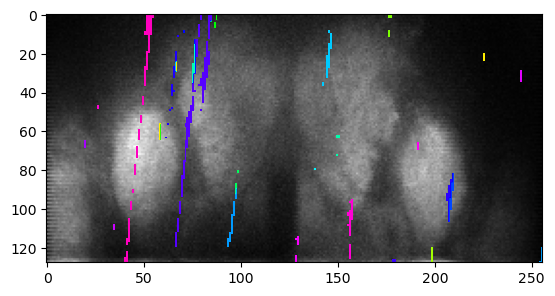

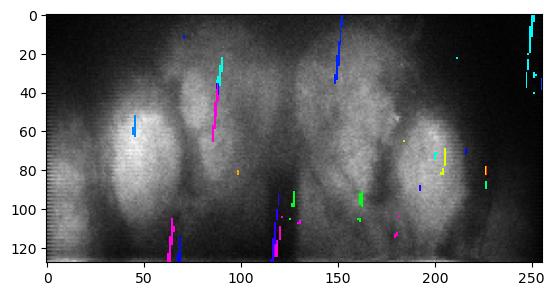

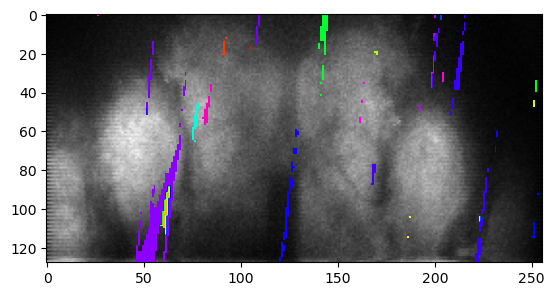

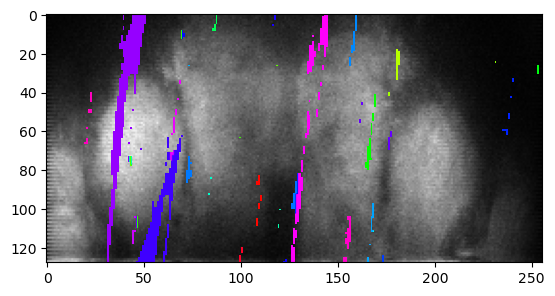

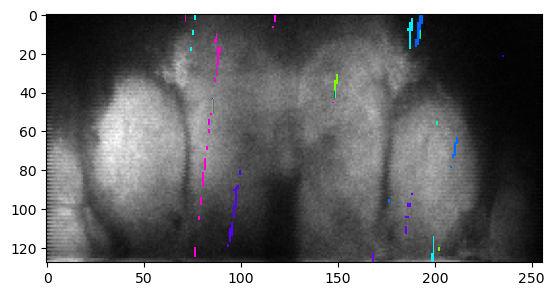

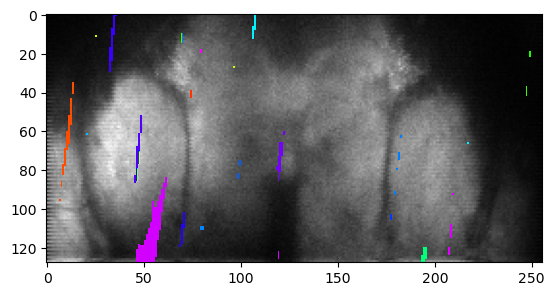

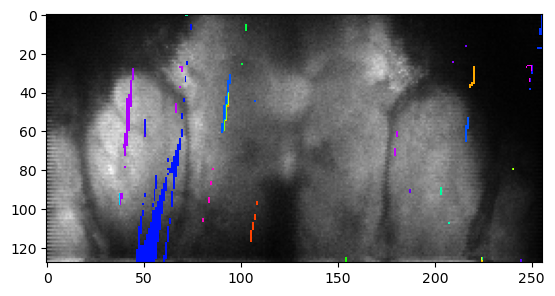

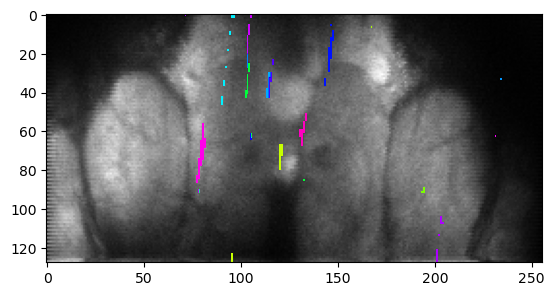

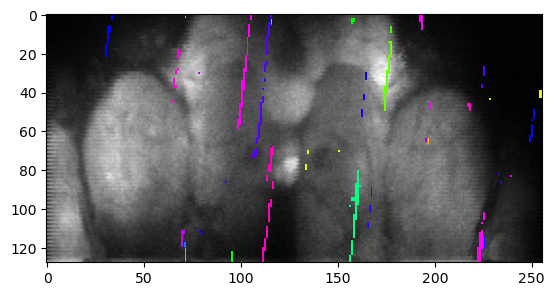

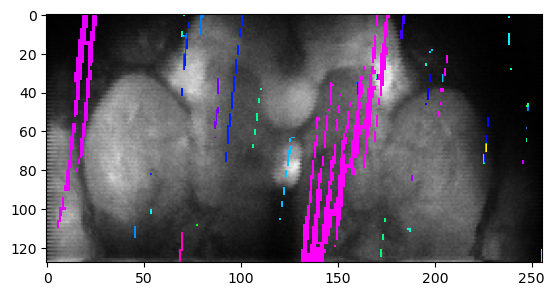

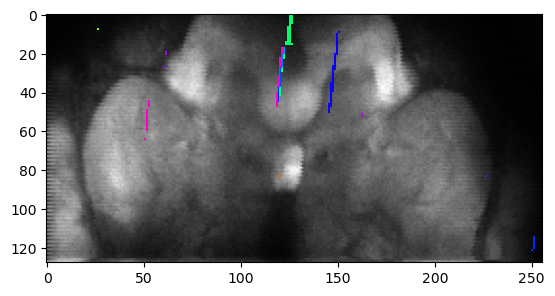

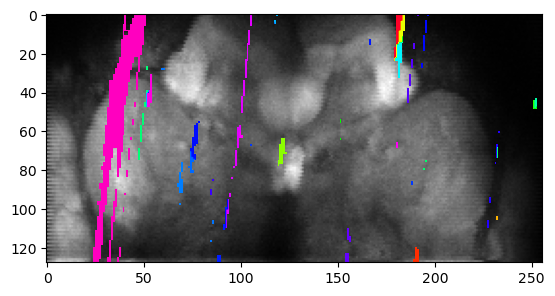

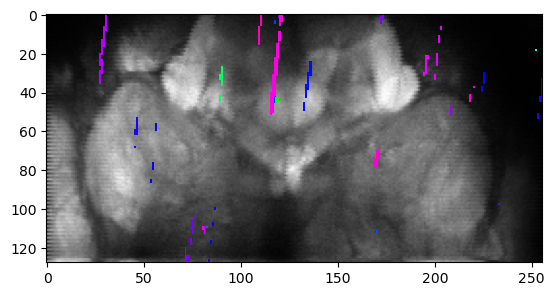

In [81]:
# Plot all audio-correlated rois for each slice

for slice_idx in range(20):
    matplotlib.rcParams['pdf.fonttype']=42
    plt.figure()
    im1 = plt.imshow(volume_img[:,:,slice_idx],cmap = 'gray')
    
    im2 = plt.imshow(audio_rois_masked[:,:,slice_idx], alpha = 1, cmap = 'gist_rainbow')
    #plt.title('Roi {} slice {}'.format(roi_audio[i],slice_audio[i]))
    
    plt.savefig(f"{plot_dir}/{slice_idx}_audiocorr_rois.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"{plot_dir}/{slice_idx}_audiocorr_rois.png", format="png", bbox_inches="tight")
    

In [ ]:
# Plot all the auditory rois singly (need to save)

for i in np.arange(len(audio_correlated)):
    plt.figure()
    plt.imshow(roi_pos[:,:,slice_audio[i]]==roi_audio[i])
    plt.title('Roi {} slice {}'.format(roi_audio[i],slice_audio[i]))
    